# Experiments vs simulations: Quads design (3dp pla + blue shims) for switching between focusing and protection


## Imports


In [1]:
import matplotlib
import matplotlib.pyplot as plt
from typing import List, Union, Literal
from difflexmm.plotting import generate_animation
from difflexmm.geometry import compute_inertia
from difflexmm.utils import save_data, load_data, SolutionData
from difflexmm.energy import ligament_strains
from difflexmm.kinematics import block_to_node_kinematics
from scripts.tracking.utils import smooth_fields_SG
from problems.quads_kinetic_energy_static_tuning import OptimizationProblem
import cv2

from pathlib import Path
import pandas as pd
import jax.numpy as jnp
from jax import vmap
from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type

plt.style.use(["science", "grid"])
%matplotlib widget

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Paths

In [2]:
# Where to load/save data
data_folder = Path("../../data/quads_focusing_vs_protection_static_tuning_3dp_pla_shims")
# Where to save plots and animations
out_folder = Path("../../out/quads_focusing_vs_protection_static_tuning_3dp_pla_shims")

## Problem info


NOTE: Either define the problem info here or load it from an optimization file.


In [3]:
# NOTE: Units are mm, N, s

# Retrieve design info from optimization data
optimization_filename = f"opt_with_angle_30_and_length_3_constraints_quads_24x18_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_initial_angle_25.0_target_size_(2, 2)_target_shifts_((2, 2), (2, 2))_compressive_strains_(0.01, 0.08)_weights_(0.75, -0.25)"
optimization = OptimizationProblem.from_dict(
    load_data(
        f"{data_folder}/{optimization_filename}.pkl",
    )
)
problem = optimization.forward_problem
# Set up the forward problem
problem.setup()
geometry = problem.geometry

# Select the best design
design_values = optimization.design_values[-1]

# Subfolder for videos and tracking data
design_name = optimization_filename


## Load tracking data


In [4]:
# Find all data files in the dynamic-data folder
tracked_data_paths = sorted(list(Path(
    f"{data_folder}/{design_name}/dynamic-data/tracking_exp/").glob("*.pkl")), key=lambda p: p.stem[-3:])

# Load the tracked data as a dataframe
# NOTE: Make sure the filenames are consistent as voltages and frequencies are extracted from the filenames.
tracked_data = pd.DataFrame({
    "label": [p.stem for p in tracked_data_paths],
    "shaker_mode": [p.stem.split("_")[-6] for p in tracked_data_paths],
    "compression": [float(p.stem.split("_")[-4]) for p in tracked_data_paths],
    "voltage": [float(p.stem.split("_")[-3][:-2]) for p in tracked_data_paths],
    "frequency": [float(p.stem.split("_")[-2][:-2]) for p in tracked_data_paths],
    "data": [SolutionData(**load_data(p)) for p in tracked_data_paths],
})

excited_blocks_ids = problem.driven_blocks_ids
# Smooth tracking data
tracked_data.data = tracked_data.apply(
    lambda row: row.data._replace(fields=smooth_fields_SG(
        row.data.fields, window_length=[[11, 11, 19], [21, 21, 25]], polyorder=2)),
    axis=1,
)
tracked_data

,label,shaker_mode,compression,voltage,frequency,data
0,exp_shaker_burst_compression_0.00_100mV_30Hz_F162,burst,0.00,100.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
1,exp_shaker_burst_compression_0.00_200mV_30Hz_F163,burst,0.00,200.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
2,exp_shaker_burst_compression_0.00_300mV_30Hz_F164,burst,0.00,300.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
3,exp_shaker_burst_compression_0.00_400mV_30Hz_F165,burst,0.00,400.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
4,exp_shaker_burst_compression_0.01_100mV_30Hz_F171,burst,0.01,100.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
5,exp_shaker_burst_compression_0.01_200mV_30Hz_F172,burst,0.01,200.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
6,exp_shaker_burst_compression_0.01_300mV_30Hz_F173,burst,0.01,300.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
7,exp_shaker_burst_compression_0.01_400mV_30Hz_F174,burst,0.01,400.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
8,exp_shaker_burst_compression_0.08_100mV_30Hz_F175,burst,0.08,100.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
9,exp_shaker_burst_compression_0.08_200mV_30Hz_F176,burst,0.08,200.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."


## Solve forward simulation with experimental input


In [ ]:
# NOTE: Filter experiments that we want to simulate
tracked_data_to_simulate = tracked_data  # [(tracked_data["voltage"] <= 100.)]

for row in tracked_data_to_simulate.itertuples():
    # Interpolate the shaker input to the simulation timepoints
    def excited_blocks_fn(t):
        return jnp.interp(t, row.data.timepoints - row.data.timepoints[0], row.data.fields[:, 0, excited_blocks_ids[0], 0])
    # Setup the problem
    problem.simulation_time_dynamic = row.data.timepoints[-1] - \
        row.data.timepoints[0]
    problem.n_timepoints = len(row.data.timepoints)
    problem.setup(excited_blocks_fn=excited_blocks_fn)
    # Solve the problem
    solution_data = problem.solve(
        optimization.design_values[-1],
        # This is ignored as we are using the excited_blocks_fn
        optimization.forward_input.amplitude[0],
        # This is ignored as we are using the excited_blocks_fn
        optimization.forward_input.loading_rate[0],
        row.compression,  # This is used for static precompression
        # This is used for static precompression
        optimization.forward_input.compressive_strain_rate[0],
        full_simulation_time=False,
    )
    # Save the solution
    save_data(
        f"{data_folder}/{design_name}/dynamic-data/simulation_exp/{row.label}.pkl",
        solution_data._asdict()
    )


## Load simulation data


In [5]:
# Find all data files in the dynamic-data folder
simulation_data_paths = sorted(list(Path(
    f"{data_folder}/{design_name}/dynamic-data/simulation_exp/").glob("*.pkl")), key=lambda p: p.stem[-3:])

# Load the simulation data as a dataframe
# NOTE: Make sure the filenames are consistent as voltages and frequencies are extracted from the filenames.
simulation_data = pd.DataFrame({
    "label": [p.stem for p in simulation_data_paths],
    "shaker_mode": [p.stem.split("_")[-6] for p in simulation_data_paths],
    "compression": [float(p.stem.split("_")[-4]) for p in simulation_data_paths],
    "voltage": [float(p.stem.split("_")[-3][:-2]) for p in simulation_data_paths],
    "frequency": [float(p.stem.split("_")[-2][:-2]) for p in simulation_data_paths],
    "data": [SolutionData(**load_data(p)) for p in simulation_data_paths],
})
simulation_data

,label,shaker_mode,compression,voltage,frequency,data
0,exp_shaker_burst_compression_0.00_100mV_30Hz_F162,burst,0.00,100.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
1,exp_shaker_burst_compression_0.00_200mV_30Hz_F163,burst,0.00,200.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
2,exp_shaker_burst_compression_0.00_300mV_30Hz_F164,burst,0.00,300.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
3,exp_shaker_burst_compression_0.00_400mV_30Hz_F165,burst,0.00,400.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
4,exp_shaker_burst_compression_0.01_100mV_30Hz_F171,burst,0.01,100.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
5,exp_shaker_burst_compression_0.01_200mV_30Hz_F172,burst,0.01,200.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
6,exp_shaker_burst_compression_0.01_300mV_30Hz_F173,burst,0.01,300.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
7,exp_shaker_burst_compression_0.01_400mV_30Hz_F174,burst,0.01,400.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
8,exp_shaker_burst_compression_0.08_100mV_30Hz_F175,burst,0.08,100.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."
9,exp_shaker_burst_compression_0.08_200mV_30Hz_F176,burst,0.08,200.0,30.0,"([[0.6129194328834726, 0.9305536807769724], [1..."


## Compare experiments and simulations


### Plotting functions


In [10]:
def exp_vs_sim_error(simulation_data, tracked_data):
    return jnp.linalg.norm(
        simulation_data.fields[:, 0, :, :2] - tracked_data.fields[:, 0, :, :2],
        axis=-1
    )


def exp_vs_sim_error_min_max(simulation_data, tracked_data):
    error_min = jnp.abs(simulation_data.fields[:, 0, :, :].min(axis=0) - tracked_data.fields[:, 0, :, :].min(axis=0))
    error_max = jnp.abs(simulation_data.fields[:, 0, :, :].max(axis=0) - tracked_data.fields[:, 0, :, :].max(axis=0))
    return error_min, error_max


In [11]:
def plot_exp_vs_sim_error_evolution(simulation_data, tracked_data):
    fig, axes = plt.subplots(figsize=(7, 3), constrained_layout=True)
    axes.plot(
        tracked_data.timepoints,
        exp_vs_sim_error(simulation_data, tracked_data),
        lw=1,
        color="gray",
        alpha=0.2
    )

    axes.set(xlabel="Time [s]", ylabel="Displacement error [mm]")
    axes.set(title="Experiment vs simulation - Error evolution")
    return fig, axes


def plot_exp_vs_sim_error_contour(simulation_data, tracked_data):
    fig, axes = plt.subplots(figsize=(
        7, 7*(geometry.n2_blocks)/geometry.n1_blocks), constrained_layout=True)
    plot = axes.tricontourf(
        tracked_data.block_centroids[:, 0],
        tracked_data.block_centroids[:, 1],
        exp_vs_sim_error(simulation_data, tracked_data).max(axis=0),
        levels=50
    )

    axes.set(xlabel="x [mm]", ylabel="y [mm]")
    axes.set(title="Experiment vs simulation - Max instantaneous error")
    axes.axis("equal")
    fig.colorbar(plot, label="Max instantaneous error [mm]", pad=0.02)
    return fig, axes


def plot_exp_vs_sim_min_max_error_contour(simulation_data, tracked_data):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(
        8, 4.5), sharex=True, sharey=True, constrained_layout=True)

    error_min, error_max = exp_vs_sim_error_min_max(
        simulation_data, tracked_data)

    plot = axes[0][0].tricontourf(
        tracked_data.block_centroids[:, 0],
        tracked_data.block_centroids[:, 1],
        error_max[:, :2].max(axis=-1),
        levels=50
    )

    axes[0][0].set(ylabel="y [mm]", aspect="equal")
    fig.colorbar(plot, ax=axes[0][0],
                 label="Peak displacement error [mm]", pad=0.02)

    plot = axes[0][1].tricontourf(
        tracked_data.block_centroids[:, 0],
        tracked_data.block_centroids[:, 1],
        error_min[:, :2].max(axis=-1),
        levels=50
    )

    axes[0][1].set(aspect="equal")
    fig.colorbar(plot, ax=axes[0][1],
                 label="Trough displacement error [mm]", pad=0.02)

    plot = axes[1][0].tricontourf(
        tracked_data.block_centroids[:, 0],
        tracked_data.block_centroids[:, 1],
        error_max[:, 2],
        levels=50
    )

    axes[1][0].set(xlabel="x [mm]", ylabel="y [mm]", aspect="equal")
    fig.colorbar(plot, ax=axes[1][0],
                 label="Peak rotation error [rad]", pad=0.02)

    plot = axes[1][1].tricontourf(
        tracked_data.block_centroids[:, 0],
        tracked_data.block_centroids[:, 1],
        error_min[:, 2],
        levels=50
    )

    axes[1][1].set(xlabel="x [mm]", aspect="equal")
    fig.colorbar(plot, ax=axes[1][1],
                 label="Trough rotation error [rad]", pad=0.02)
    return fig, axes


def plot_error(simulation_data, tracked_data):
    plot_exp_vs_sim_error_evolution(simulation_data, tracked_data)
    plot_exp_vs_sim_error_contour(simulation_data, tracked_data)
    plot_exp_vs_sim_min_max_error_contour(simulation_data, tracked_data)


def block_ids_row(row_id):
    return jnp.arange(geometry.n1_blocks) + row_id * geometry.n1_blocks


def block_ids_column(column_id):
    return jnp.arange(geometry.n2_blocks) * geometry.n1_blocks + column_id


def plot_field_history_along_section(simulation_data, tracked_data, field_id, block_ids):
    fig, axes = plt.subplots(figsize=(7, 3), constrained_layout=True)
    axes.plot(
        tracked_data.timepoints,
        tracked_data.fields[:, field_id[0], block_ids, field_id[1]],
        lw=1,
        color="#2c3e50",
        label="Experiment",
    )
    axes.plot(
        simulation_data.timepoints,
        simulation_data.fields[:, field_id[0], block_ids, field_id[1]],
        lw=1,
        color="#2980b9",
        label="Simulation",
    )
    axes.set(xlabel="Time [s]", ylabel="DOF")
    dof_label = ["x", "y", "theta"][field_id[1]]
    axes.set(
        title=f"Experiment vs simulation - DOF: {'Displacement' if field_id[0]==0 else 'Velocity'}-{dof_label}")
    legend = axes.legend(["Experiment", "Simulation"])
    legend.legendHandles[0].set_color("#2c3e50")
    legend.legendHandles[1].set_color("#2980b9")
    return fig, axes


def energy_profile(velocity, blocks_inertia):
    # velocity is (n_time_steps, n_blocks, 3)
    # blocks_inertia is (n_blocks, 3)
    return 0.5*jnp.sum(velocity**2 * blocks_inertia, axis=-1)


def plot_field_profile_x_section(comparison_data, row_id, field: Literal["u", "v", "k"], target_response=None, synthetic_responses=None, colors=None, synthetic_responses_colors=None, figsize=(10, 4), fontsize=14, grid=True):
    fig, axes = plt.subplots(figsize=figsize, constrained_layout=True)
    # Colors based on amplitude
    colors = [
        plt.get_cmap("Blues")((lambda x: 0.3 + (x-comparison_data.amplitude.min())*(1-0.3)/(comparison_data.amplitude.max()-comparison_data.amplitude.min()))(row.amplitude)) for row in comparison_data.itertuples()
    ] if colors is None else colors

    simulation_data_list = comparison_data.simulation_data.values
    tracked_data_list = comparison_data.tracked_data.values
    labels = [
        rf"{row.amplitude:.0f}mm, {row.frequency:.0f}Hz, {row.compression*100:.0f}\%" for row in comparison_data.itertuples()
    ]
    if field == "peak_u":
        def field_values_fn(data): return jnp.linalg.norm(
            data.fields[:, 0, block_ids_row(row_id), :2], axis=-1).max(axis=0)
        ylabel = "Peak displacement [mm]"
    elif field == "peak_v":
        def field_values_fn(data): return jnp.linalg.norm(
            data.fields[:, 1, block_ids_row(row_id), :2], axis=-1).max(axis=0)*1e-3
        ylabel = "Peak velocity [m/s]"
    elif field == "peak_k":
        def field_values_fn(data):
            blocks_inertia = compute_inertia(
                vertices=data.centroid_node_vectors, density=problem.density)
            return energy_profile(
                data.fields[:, 1, block_ids_row(row_id), :],
                blocks_inertia[block_ids_row(row_id)]
            ).max(axis=0)
        ylabel = "Peak kinetic energy [mJ]"
    elif field == "avg_u":
        def field_values_fn(data): return jnp.linalg.norm(
            data.fields[:, 0, block_ids_row(row_id), :2], axis=-1).mean(axis=0)
        ylabel = "Average displacement [mm]"
    elif field == "avg_v":
        def field_values_fn(data): return jnp.linalg.norm(
            data.fields[:, 1, block_ids_row(row_id), :2], axis=-1).mean(axis=0)*1e-3
        ylabel = "Average velocity [m/s]"
    elif field == "avg_k":
        def field_values_fn(data):
            blocks_inertia = compute_inertia(
                vertices=data.centroid_node_vectors, density=problem.density)
            return energy_profile(
                data.fields[:, 1, block_ids_row(row_id), :],
                blocks_inertia[block_ids_row(row_id)]
            ).mean(axis=0)
        ylabel = "Average kinetic energy [mJ]"
    else:
        raise ValueError(f"Unknown field: {field}")

    for simulation_data, tracked_data, color, label in zip(simulation_data_list, tracked_data_list, colors, labels):
        axes.plot(
            jnp.arange(geometry.n1_blocks),
            field_values_fn(tracked_data),
            lw=2,
            ls="--",
            color=color,
            label=f"Exp: {label}",
        )
        axes.plot(
            jnp.arange(geometry.n1_blocks),
            field_values_fn(simulation_data),
            lw=2,
            ls="-",
            color=color,
            label=f"Sim: {label}",
        )

    if target_response is not None:
        axes.plot(
            jnp.arange(geometry.n1_blocks),
            field_values_fn(target_response),
            lw=2,
            ls="-",
            color="firebrick",
            label=f"Target response",
        )

    if synthetic_responses is not None:
        cmap = plt.get_cmap("Oranges")
        colors = [cmap(i) for i in jnp.linspace(0.4, 1, len(synthetic_responses))
                  ] if synthetic_responses_colors is None else synthetic_responses_colors
        for synthetic_response, color in zip(synthetic_responses, colors):
            axes.plot(
                jnp.arange(geometry.n1_blocks),
                field_values_fn(synthetic_response),
                lw=2,
                ls="-",
                color=color,
                label=f"Synthetic response",
            )

    axes.axvspan(
        (geometry.n1_blocks -
         optimization.target_sizes[0][0]-1)/2 + optimization.target_shifts[0][0],
        (geometry.n1_blocks +
         optimization.target_sizes[0][0]-1)/2 + optimization.target_shifts[0][0],
        color="#bdc3c7", alpha=0.3, label="Focusing/protected region"
    )
    axes.axhline(y=0, color="black")
    axes.set_xlabel(r"$x$-direction [\# units]", fontsize=fontsize)
    axes.set_ylabel(ylabel, fontsize=fontsize)
    axes.tick_params(labelsize=fontsize-2)

    axes.legend(loc="upper left", framealpha=0.8, fontsize=fontsize)

    if not grid:
        axes.grid(False)

    return fig, axes


def plot_shaker_input_paper(comparison_data, target_response=None, figsize=(7, 3), fontsize=14, xlim=None, ylim=None, legend=True, synthetic_inputs=[], lw=2, colors=None):
    fig, axes = plt.subplots(figsize=figsize, constrained_layout=True)
    # Colors based on amplitude
    colors = [
        plt.get_cmap("Blues")((lambda x: 0.3 + (x-comparison_data.amplitude.min())*(1-0.3)/(comparison_data.amplitude.max()-comparison_data.amplitude.min()))(row.amplitude)) for row in comparison_data.itertuples()
    ] if colors is None else colors

    for row, color in zip(comparison_data.itertuples(), colors):
        axes.plot(
            row.tracked_data.timepoints*1e3,
            row.tracked_data.fields[:, 0, excited_blocks_ids[0], 0],
            label=rf"{row.label.split('_')[-1]}: {row.voltage:.0f}mV, {row.frequency:.0f}Hz, {row.compression*100:.0f}\%",
            lw=lw,
            color=color,
        )

    if len(synthetic_inputs) > 0:
        # Use an orange to white colormap for synthetic inputs
        cmap = plt.get_cmap("Oranges")
        colors = [cmap(i) for i in jnp.linspace(0.4, 1, len(synthetic_inputs))]
        for (amp, freq), color in zip(synthetic_inputs, colors):
            timepoints = comparison_data.iloc[0].tracked_data.timepoints
            delay = timepoints[jnp.where(comparison_data.iloc[0].tracked_data.fields[:,
                                         0, excited_blocks_ids[0], 0] > 1e-2)[0][0]]
            axes.plot(
                timepoints*1e3,
                (lambda t: jnp.where((t > 0.) & (t < freq**-1), amp *
                                     (1-jnp.cos(2*jnp.pi*freq*t))/2, 0.))(timepoints-delay),
                lw=lw,
                ls="-",
                color=color,
                label=f"Synthetic input",
            )
    if target_response is not None:
        timepoints = comparison_data.iloc[0].tracked_data.timepoints
        delay = timepoints[jnp.where(comparison_data.iloc[0].tracked_data.fields[:,
                                     0, excited_blocks_ids[0], 0] > 1e-2)[0][0]]
        axes.plot(
            timepoints*1e3,
            (lambda t: jnp.where((t > 0.) & (t < problem.loading_rate**-1), problem.amplitude *
             (1-jnp.cos(2*jnp.pi*problem.loading_rate*t))/2, 0.))(timepoints-delay),
            lw=lw,
            ls="-",
            color="firebrick",
            label=f"Ideal input",
        )

    axes.axhline(0, color="black", ls="-", lw=1, zorder=0)
    axes.set_xlabel("Time [ms]", fontsize=fontsize)
    axes.set_ylabel("Displacement [mm]", fontsize=fontsize)
    axes.tick_params(labelsize=fontsize)
    # axes.set_title("Experimental input", fontsize=fontsize)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(loc='upper right', framealpha=0.8, fontsize=fontsize)
    axes.grid(False)

    return fig, axes


def plot_energy_evolution_list(comparison_data, block_ids=None, figsize=(10, 7), fontsize=None, grid=True, energy_ratio=False):

    fig, axes = plt.subplots(
        figsize=figsize, sharex=True, constrained_layout=True)
    # Colors based on amplitude
    colors = [
        plt.get_cmap("Blues")((lambda x: 0.3 + (x-comparison_data.amplitude.min())*(1-0.3)/(comparison_data.amplitude.max()-comparison_data.amplitude.min()))(row.amplitude)) for row in comparison_data.itertuples()
    ]

    simulation_data_list = comparison_data.simulation_data.values
    tracked_data_list = comparison_data.tracked_data.values
    # labels = [
    #     f"{row.label.split('_')[-1]}: {row.voltage:.0f}mV, {row.frequency:.0f}Hz" for row in comparison_data.itertuples()
    # ]
    labels = [
        f"{row.amplitude:.0f}mm, {row.frequency:.0f}Hz" for row in comparison_data.itertuples()
    ]

    _block_ids = block_ids if block_ids is not None else jnp.arange(
        simulation_data_list[0].block_centroids.shape[0])
    if block_ids == "target":
        target_size = optimization.target_size
        target_shift = optimization.target_shift
        _block_ids = jnp.array([
            j * problem.n1_blocks + i
            for i in range((problem.n1_blocks-target_size[0])//2 + target_shift[0], (problem.n1_blocks+target_size[0])//2 + target_shift[0])
            for j in range((problem.n2_blocks-target_size[1])//2 + target_shift[1], (problem.n2_blocks+target_size[1])//2 + target_shift[1])
        ])

    if energy_ratio:
        def field_values_fn(data):
            return jnp.sum(
                energy_profile(
                    data.fields[:, 1, _block_ids, :],
                    compute_inertia(vertices=data.centroid_node_vectors,
                                    density=problem.density)[_block_ids]
                ),
                axis=-1
            )/jnp.sum(
                energy_profile(
                    data.fields[:, 1, jnp.setdiff1d(jnp.arange(
                        data.block_centroids.shape[0]), _block_ids), :],
                    compute_inertia(vertices=data.centroid_node_vectors,
                                    density=problem.density)[jnp.setdiff1d(jnp.arange(data.block_centroids.shape[0]), _block_ids)]
                ),
                axis=-1
            )
    else:
        def field_values_fn(data):
            return jnp.sum(
                energy_profile(
                    data.fields[:, 1, _block_ids, :],
                    compute_inertia(vertices=data.centroid_node_vectors,
                                    density=problem.density)[_block_ids]
                ),
                axis=-1
            )

    for simulation_data, tracked_data, color, label in zip(simulation_data_list, tracked_data_list, colors, labels):
        axes.plot(
            tracked_data.timepoints*1e3,
            field_values_fn(tracked_data),
            lw=3,
            ls="--",
            color=color,
            label=f"Experiment: {label}",
        )
        axes.plot(
            simulation_data.timepoints*1e3,
            field_values_fn(simulation_data),
            lw=3,
            ls="-",
            color=color,
            label=f"Simulation: {label}",
        )

    axes.set_xlabel(r"Time [ms]", fontsize=fontsize)
    if block_ids == "target":
        axes.set_ylabel(
            "Target kinetic energy [mJ]" if not energy_ratio else "Kinetic energy ratio", fontsize=fontsize)
    else:
        axes.set_ylabel("Kinetic energy [mJ]", fontsize=fontsize)
    axes.axhline(y=0, color="black")
    axes.legend(loc="upper right", framealpha=0.8,
                fontsize=0.8*fontsize, fancybox=True)
    # Change fontsize for all axes
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)

    return fig, axes

### Dataframe for comparison


In [6]:
# Create a dataframe to compare the simulation and experimental data
comparison_data = simulation_data.copy()
comparison_data = comparison_data.rename(columns={"data": "simulation_data"})
# Merge the simulation and experimental dataframes
comparison_data = comparison_data.merge(
    tracked_data,
    on=["label", "shaker_mode", "compression", "voltage", "frequency"],
    how="left"
)
comparison_data = comparison_data.rename(columns={"data": "tracked_data"})

# Add an amplitude column at position 5 to the comparison dataframe
comparison_data.insert(5, "amplitude", None)
# Add the amplitude values by computing peak displacement of the shaker
for row in comparison_data.itertuples():
    comparison_data.at[row.Index, "amplitude"] = row.tracked_data.fields[:,
                                                                         0, excited_blocks_ids[0], 0].max()

comparison_data

,label,shaker_mode,compression,voltage,frequency,amplitude,simulation_data,tracked_data
0,exp_shaker_burst_compression_0.00_100mV_30Hz_F162,burst,0.00,100.0,30.0,2.8995804925201494,"([[0.6129194328834726, 0.9305536807769724], [1...","([[0.6129194328834726, 0.9305536807769724], [1..."
1,exp_shaker_burst_compression_0.00_200mV_30Hz_F163,burst,0.00,200.0,30.0,5.8758923305085595,"([[0.6129194328834726, 0.9305536807769724], [1...","([[0.6129194328834726, 0.9305536807769724], [1..."
2,exp_shaker_burst_compression_0.00_300mV_30Hz_F164,burst,0.00,300.0,30.0,8.483052817487975,"([[0.6129194328834726, 0.9305536807769724], [1...","([[0.6129194328834726, 0.9305536807769724], [1..."
3,exp_shaker_burst_compression_0.00_400mV_30Hz_F165,burst,0.00,400.0,30.0,10.44719450240226,"([[0.6129194328834726, 0.9305536807769724], [1...","([[0.6129194328834726, 0.9305536807769724], [1..."
4,exp_shaker_burst_compression_0.01_100mV_30Hz_F171,burst,0.01,100.0,30.0,3.133063268286091,"([[0.6129194328834726, 0.9305536807769724], [1...","([[0.6129194328834726, 0.9305536807769724], [1..."
5,exp_shaker_burst_compression_0.01_200mV_30Hz_F172,burst,0.01,200.0,30.0,5.69650424744821,"([[0.6129194328834726, 0.9305536807769724], [1...","([[0.6129194328834726, 0.9305536807769724], [1..."
6,exp_shaker_burst_compression_0.01_300mV_30Hz_F173,burst,0.01,300.0,30.0,8.076748697795205,"([[0.6129194328834726, 0.9305536807769724], [1...","([[0.6129194328834726, 0.9305536807769724], [1..."
7,exp_shaker_burst_compression_0.01_400mV_30Hz_F174,burst,0.01,400.0,30.0,9.827159362738199,"([[0.6129194328834726, 0.9305536807769724], [1...","([[0.6129194328834726, 0.9305536807769724], [1..."
8,exp_shaker_burst_compression_0.08_100mV_30Hz_F175,burst,0.08,100.0,30.0,2.4382127763145065,"([[0.6129194328834726, 0.9305536807769724], [1...","([[0.6129194328834726, 0.9305536807769724], [1..."
9,exp_shaker_burst_compression_0.08_200mV_30Hz_F176,burst,0.08,200.0,30.0,4.375068933434358,"([[0.6129194328834726, 0.9305536807769724], [1...","([[0.6129194328834726, 0.9305536807769724], [1..."


### Plots


#### Input signals


Text(0, 0.5, '$u_\\text{input}$ [mm]')

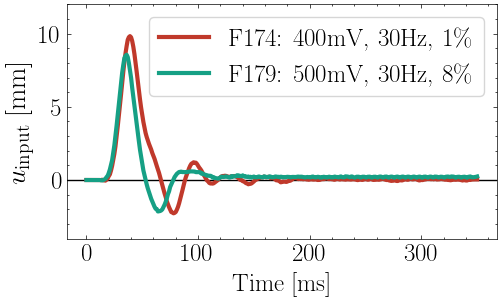

In [114]:
fig, axes = plot_shaker_input_paper(
    # comparison_data.loc[[7, 12]],
    comparison_data.loc[[5, 9]],
    figsize=(5, 3),
    fontsize=18,
    ylim=(-4, 12),
    legend=True,
    lw=3,
    colors=["#c0392b", "#16a085"],
)
axes.set_ylabel(r"$u_\text{input}$ [mm]", fontsize=20)
# axes.set_xlabel(r"Time [ms]", fontsize=20, color="white")
# # Set all spines and ticks to white
# for spine in axes.spines.values():
#     spine.set_edgecolor("white")
# # for tick in axes.get_xticklabels() + axes.get_yticklabels():
# #     tick.set_color("white")
# axes.tick_params(axis="both", which="both", colors='white')
# axes.axhline(0, color="white", zorder=0)
# fig.savefig(
#     f"profiles/shaker_inputs_{comparison_data.loc[[7]].voltage.values.tolist()}mV.png", bbox_inches="tight", dpi=300, transparent=True)

#### Kinetic energy profiles vs compressive strain


##### Generate sweep of responses for different compressive strains

In [7]:
# Used to extract experimental input
tracked_exp = comparison_data.loc[5].tracked_data
compressions = [0.04, 0.05, 0.06, 0.07, 0.09]
solution_data_sims = []
for compression in compressions:
    # Interpolate the shaker input to the simulation timepoints
    def excited_blocks_fn(t):
        return jnp.interp(t, tracked_exp.timepoints - tracked_exp.timepoints[0], tracked_exp.fields[:, 0, excited_blocks_ids[0], 0])
    # Setup the problem
    problem.simulation_time_dynamic = tracked_exp.timepoints[-1] - \
        tracked_exp.timepoints[0]
    problem.n_timepoints = len(tracked_exp.timepoints)
    problem.setup(excited_blocks_fn=excited_blocks_fn)
    # Solve the problem
    solution_data_sims.append(
        problem.solve(
            optimization.design_values[-1],
            # This is ignored as we are using the excited_blocks_fn
            optimization.forward_input.amplitude[0],
            # This is ignored as we are using the excited_blocks_fn
            optimization.forward_input.loading_rate[0],
            compression,  # This is used for static precompression
            # This is used for static precompression
            optimization.forward_input.compressive_strain_rate[0],
            full_simulation_time=False,
        )
    )

save_data(
    f"{data_folder}/{optimization_filename}/compression_sweep_simulation_data_exp_input.pkl",
    pd.DataFrame(
        {
            "compression": compressions,
            "simulation_data": [sol._asdict() for sol in solution_data_sims],
        }
    ),
)

Data saved at ../../data/quads_focusing_vs_protection_static_tuning_3dp_pla_shims/opt_with_angle_30_and_length_3_constraints_quads_24x18_excited_blocks_2_amplitude_7.50_loading_rate_30.00_input_shift_0_initial_angle_25.0_target_size_(2, 2)_target_shifts_((2, 2), (2, 2))_compressive_strains_(0.01, 0.08)_weights_(0.75, -0.25)/compression_sweep_simulation_data_exp_input.pkl


In [8]:
compression_sweep_data = load_data(
    f"../../data/{optimization.name}/{optimization_filename}/compression_sweep_simulation_data_exp_input.pkl",
)
compression_sweep_data.simulation_data = compression_sweep_data.simulation_data.apply(lambda x: SolutionData(**x))
compression_sweep_data

,compression,simulation_data
0,0.04,"([[0.6129194328834726, 0.9305536807769724], [1..."
1,0.05,"([[0.6129194328834726, 0.9305536807769724], [1..."
2,0.06,"([[0.6129194328834726, 0.9305536807769724], [1..."
3,0.07,"([[0.6129194328834726, 0.9305536807769724], [1..."
4,0.09,"([[0.6129194328834726, 0.9305536807769724], [1..."


##### Plot kinetic energy profiles

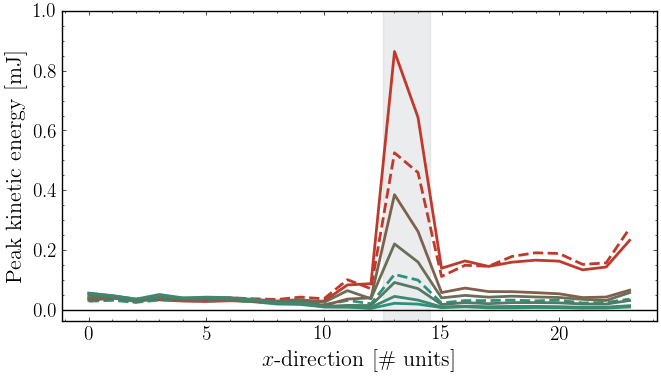

In [14]:
# For Fig 4
compressions = compression_sweep_data.compression
solution_data_sims = compression_sweep_data.simulation_data
norm = plt.Normalize(vmin=0.01, vmax=0.09)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "cmap",
    ("#c0392b", "#16a085"),
)


def compression_cmap(compression):
    return cmap(norm(compression))


fig, axes = plot_field_profile_x_section(
    comparison_data.loc[[5, 9]],
    field="peak_k",
    row_id=11,
    synthetic_responses=solution_data_sims[:-1],
    grid=False,
    figsize=(6.6, 3.75),
    fontsize=16,
    colors=compression_cmap(comparison_data.loc[[5, 9]].compression),
    synthetic_responses_colors=compression_cmap(compressions[:-1]),
)
axes.set_ylim(None, 1.)
# Make spines 1pt thick
for spine in axes.spines.values():
    spine.set_linewidth(1)
# Remove legend
axes.legend().remove()
# # Set linewidth of 0.01 and 0.08 to 2.5pt
# for line in axes.lines[:4]:
#     line.set_linewidth(2.5)
# for line in axes.lines[4:-1]:
#     line.set_linewidth(1.5)
out_path = Path(f"{out_folder}/{design_name}/profiles/kinetic_energy_profile_x_section.png")
out_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(out_path, bbox_inches="tight", dpi=300)


#### Snapshots of the deformed configuration with experimental input


In [15]:
import numpy as np
from difflexmm.geometry import current_coordinates


def plot_tracked_video_frame(video_filename, tracked_data, frame_number, timepoint, calib_xy, ROI_X, ROI_Y, alpha_overlay=0.8, origin_px=(0, 0), cmap="inferno", figsize=(8, 5), ax=None, field_values_max=None):
    # Load the video named with the label of the simulation using opencv
    video = cv2.VideoCapture(f"{video_filename}")
    # Get frame number 100
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    # Read the frame
    _, frame = video.read()
    # Add alpha channel
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2RGBA)
    # Restrict the frame to the ROI
    frame = cv2.flip(frame, 0)
    frame = frame[ROI_Y[0]:ROI_Y[1], ROI_X[0]:ROI_X[1]]
    origin_px = np.array(origin_px)

    # Compute current configuration of the blocks
    block_coordinates = current_coordinates(
        vertices=tracked_data.centroid_node_vectors,
        centroids=tracked_data.block_centroids,
        angles=tracked_data.fields[timepoint, 0, :, 2],
        displacements=tracked_data.fields[timepoint, 0, :, :2],
    )
    # Compute the field values
    field_values = np.linalg.norm(
        tracked_data.fields[timepoint, 1, :, :2], axis=-1)
    field_values_max = np.linalg.norm(
        tracked_data.fields[:, 1, :, :2], axis=-1).max() if field_values_max is None else field_values_max
    # Make a colormap
    cmap = plt.get_cmap("inferno")
    # Normalize the field values
    norm = plt.Normalize(vmin=0, vmax=field_values_max)
    # Map the normalized values to colors
    field_colors = cmap(norm(field_values))
    # Draw the blocks
    overlay = frame.copy()
    for block, color in zip(block_coordinates, field_colors):
        # Convert the block coordinates to pixels
        block_px = (np.array(block) / calib_xy[0]).astype(int) + origin_px
        # Draw the shape with the color and opacity 0.5
        cv2.fillPoly(
            overlay,
            pts=[block_px],
            # Color the block according to the field value
            color=(color[0]*255, color[1]*255, color[2]*255, 255),
        )
    # Add the overlay to the frame
    frame = cv2.addWeighted(overlay, alpha_overlay, frame, 1-alpha_overlay, 0)

    # Show the frame
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    ax.imshow(frame, origin="lower")
    ax.axis("off")

    return ax.get_figure(), ax

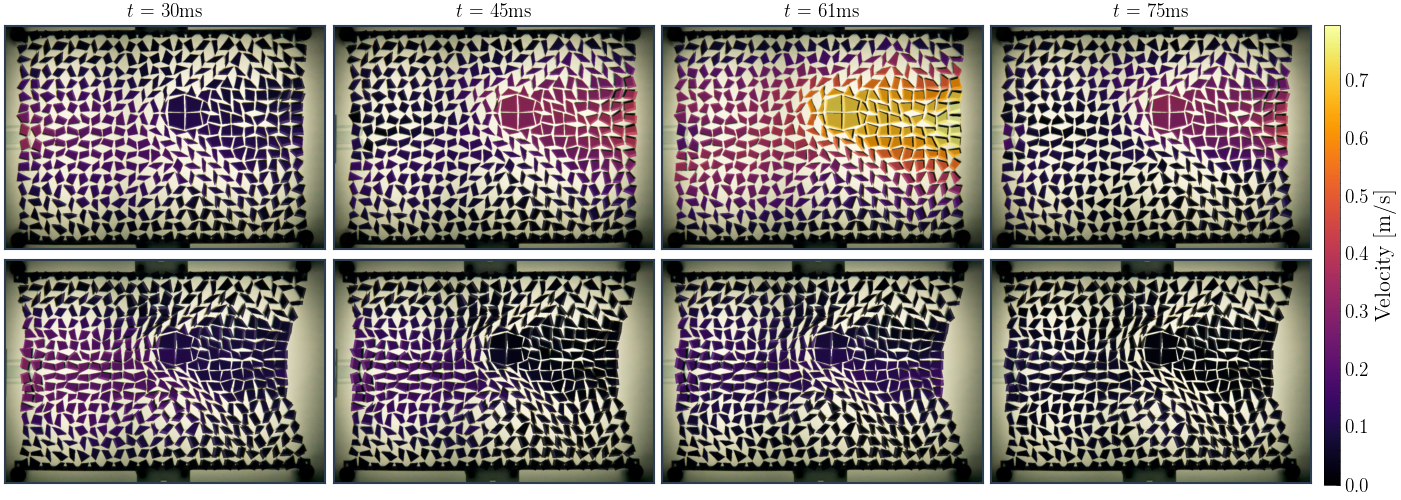

In [16]:
# Focusing at 1% compression
data_1 = comparison_data.loc[5]
field_values_max = np.linalg.norm(
    data_1.tracked_data.fields[:, 1, :, :2], axis=-1).max()
# Protection at 8% compression
data_2 = comparison_data.loc[9]
# Select frames and plot them as subplot row
timepoints = [30, 45, 61, 75]
fig, axes = plt.subplots(ncols=len(timepoints), nrows=2, figsize=(
    14, 5), constrained_layout=True)
# First row
for ax, timepoint in zip(axes[0], timepoints):
    plot_tracked_video_frame(
        video_filename=f"{data_folder}/{design_name}/videos/{data_1.label}.mp4",
        tracked_data=data_1.tracked_data,
        frame_number=timepoint+50,
        timepoint=timepoint,
        calib_xy=(0.395, 0.395),  # mm/px
        ROI_X=(155, 1165),
        ROI_Y=(10, 714),  # (5, 714),
        origin_px=(57, 30),  # px
        ax=ax,
        field_values_max=field_values_max,
    )
# Second row
for ax, timepoint in zip(axes[1], timepoints):
    plot_tracked_video_frame(
        video_filename=f"{data_folder}/{design_name}/videos/{data_2.label}.mp4",
        tracked_data=data_2.tracked_data,
        frame_number=timepoint+50,
        timepoint=timepoint,
        calib_xy=(0.395, 0.395),  # mm/px
        ROI_X=(155, 1165),
        ROI_Y=(10, 714),  # (5, 714),
        origin_px=(57, 30),  # px
        ax=ax,
        field_values_max=field_values_max,
    )

# Add time labels at the top
time_labels = [f"$t$ = {data_1.tracked_data.timepoints[timepoint]*1e3:.0f}ms" for timepoint in timepoints]
for ax, label in zip(axes[0], time_labels):
    ax.set_title(label, fontsize=14)

# Add spines to all axes
for ax in axes.flatten():
    ax.axis("on")
    for spine in ax.spines.values():
        spine.set_edgecolor("#2c3e50")
        spine.set_linewidth(1.5)    
    ax.set_xticks([])
    ax.set_yticks([])


# Add a colorbar to the last frame
cmap = plt.get_cmap("inferno")
norm = plt.Normalize(vmin=0, vmax=field_values_max*1e-3)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axes, pad=0.01, aspect=30, location="right")
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r"Velocity [m/s]", fontsize=16)

path = Path(f"{out_folder}/{design_name}/snapshots/exp_focusing_vs_protection_snapshots.png")
# Make sure parents directories exist
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(str(path), dpi=300, bbox_inches="tight")

#### Movie frames for SI - Movie S3

In [84]:
from matplotlib import patches
import numpy as np
from difflexmm.geometry import current_coordinates


def plot_tracked_video_frame(video_filename, tracked_data, frame_number, timepoint, calib_xy, ROI_X, ROI_Y, alpha_overlay=0.8, origin_px=(0, 0), cmap="inferno", figsize=(8, 5), field_values_max=None):
    # Load the video named with the label of the simulation using opencv
    video = cv2.VideoCapture(f"{video_filename}")
    # Get frame number 100
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    # Read the frame
    _, frame = video.read()
    # Add alpha channel
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2RGBA)
    # Restrict the frame to the ROI
    frame = cv2.flip(frame, 0)
    frame = frame[ROI_Y[0]:ROI_Y[1], ROI_X[0]:ROI_X[1]]
    origin_px = np.array(origin_px)

    # Compute current configuration of the blocks
    block_coordinates = current_coordinates(
        vertices=tracked_data.centroid_node_vectors,
        centroids=tracked_data.block_centroids,
        angles=tracked_data.fields[timepoint, 0, :, 2],
        displacements=tracked_data.fields[timepoint, 0, :, :2],
    )
    # Compute the field values
    field_values = np.linalg.norm(
        tracked_data.fields[timepoint, 1, :, :2], axis=-1)
    field_values_max = np.linalg.norm(
        tracked_data.fields[:, 1, :, :2], axis=-1).max() if field_values_max is None else field_values_max
    # Make a colormap
    cmap = plt.get_cmap("inferno")
    # Normalize the field values
    norm = plt.Normalize(vmin=0, vmax=field_values_max)
    # Map the normalized values to colors
    field_colors = cmap(norm(field_values))
    # Draw the blocks
    overlay = frame.copy()
    for block, color in zip(block_coordinates, field_colors):
        # Convert the block coordinates to pixels
        block_px = (np.array(block) / calib_xy[0]).astype(int) + origin_px
        # Draw the shape with the color and opacity 0.5
        cv2.fillPoly(
            overlay,
            pts=[block_px],
            # Color the block according to the field value
            color=(color[0]*255, color[1]*255, color[2]*255, 255),
        )
    # Add the overlay to the frame
    frame = cv2.addWeighted(overlay, alpha_overlay, frame, 1-alpha_overlay, 0)

    # Show the frame
    fig, ax = plt.subplots(figsize=figsize)
    # Add timepoint annotation in the bootom left corner
    ax.set_position([0, 0, 1, 1])
    ax.imshow(frame, origin="lower")
    # Add rectangle below text
    rect = patches.Rectangle((5, 5), 230, 50, linewidth=1, edgecolor="black", facecolor="black", alpha=0.9)
    ax.add_patch(rect)
    ax.text(15, 5, f"$t = {timepoint:.0f}"+"\\,\\text{ms}$",
            fontsize=14, color="white", ha="left", va="bottom")
    ax.axis("off")

    return fig, ax

In [ ]:
# Focusing at 1% compression
data = comparison_data.loc[5]
field_values_max = np.linalg.norm(
    data.tracked_data.fields[:, 1, :, :2], axis=-1).max()

timepoints = range(0, 200, 1)
plt.ioff()
for timepoint in timepoints:
    fig, axes = plot_tracked_video_frame(
        video_filename=f"{data_folder}/{design_name}/videos/{data.label}.mp4",
        tracked_data=data.tracked_data,
        frame_number=timepoint+50,
        timepoint=timepoint,
        calib_xy=(0.395, 0.395),  # mm/px
        ROI_X=(155, 1165),
        ROI_Y=(10, 714),  # (5, 714),
        origin_px=(57, 30),  # px
        field_values_max=field_values_max,
        figsize=(6, 3),
    )
    # Make sure the directory exists
    out_path = Path(
        f"{out_folder}/{optimization_filename}/movie/tracked_frames_movie/{data.label}/frame_{timepoint:04d}.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(
        str(out_path),
        # bbox_inches="tight",
        pad_inches=0,
        dpi=300,
    )
    plt.close(fig)
    print(f"Frame {timepoint} done.")
plt.ion()

In [ ]:
# Protection at 8% compression
data = comparison_data.loc[9]
field_values_max = np.linalg.norm(
    comparison_data.loc[5].tracked_data.fields[:, 1, :, :2], axis=-1).max()

timepoints = range(0, 200, 1)
plt.ioff()
for timepoint in timepoints:
    fig, axes = plot_tracked_video_frame(
        video_filename=f"{data_folder}/{design_name}/videos/{data.label}.mp4",
        tracked_data=data.tracked_data,
        frame_number=timepoint+50,
        timepoint=timepoint,
        calib_xy=(0.395, 0.395),  # mm/px
        ROI_X=(155, 1165),
        ROI_Y=(10, 714),  # (5, 714),
        origin_px=(57, 30),  # px
        field_values_max=field_values_max,
        figsize=(6, 3),
    )
    # Make sure the directory exists
    out_path = Path(
        f"{out_folder}/{optimization_filename}/movie/tracked_frames_movie/{data.label}/frame_{timepoint:04d}.png")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(
        str(out_path),
        # bbox_inches="tight",
        pad_inches=0,
        dpi=300,
    )
    plt.close(fig)
    print(f"Frame {timepoint} done.")
plt.ion()

### Animation of simulation


In [ ]:
# Animation tracked experiments
xlim, ylim = problem.geometry.get_xy_limits(*design_values) + 0.5*problem.geometry.spacing * jnp.array([-1, 1])

for row in simulation_data.itertuples():
    generate_animation(
        row.data,
        frame_range=jnp.arange(0, row.data.timepoints.shape[0], 2),
        field="u",
        deformed=True,
        out_filename=f"{out_folder}/{optimization_filename}/simulation_exp/{row.label}",
        xlim=xlim,
        ylim=ylim,
        figsize=(8, 5),
        fps=30,
        dpi=300,
        cmap="inferno",
        grid=False,
    )
